In [38]:
import pandas as pd

dataset = pd.read_csv('arquivos/supermarket_sales.csv')
dataset.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [54]:
dataset['Rating'].mean()

6.9727

In [ ]:
dataset['Rating'].mean()

6.9727

In [39]:
import openai
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

client = openai.Client()

## Cria o assistant

In [40]:
file = client.files.create(
    file=open('arquivos/supermarket_sales.csv', 'rb'),
    purpose='assistants'
)

In [41]:
assistant = client.beta.assistants.create(
    name="Analista Fianceiro Supermercados Asimov",
    instructions="Você é um analista financeiro de um supermercado. Você utiliza os dados .csv relativo às vendas \
        do supermercado para realizar as suas análises",
    tools=[{'type': 'code_interpreter'}],
    file_ids=[file.id],
    model='gpt-4-turbo-preview'
)

## Cria uma thread

In [42]:
thread = client.beta.threads.create()

## Adiciona mensagem a thread criada

In [60]:
pergunta = 'Qual é o rating médio das vendas do nosso supermercado?'
pergunta = 'Gere um gráfico pizza com o percentual de vendas por meio de pagamento'

messages = client.beta.threads.messages.create(
    thread_id=thread.id,
    role='user',
    content=pergunta
)

## Roda a thread no assistant

In [61]:
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id,
    instructions='O nome do usuário é Adriano.'
)

## Aguarda a thread rodar

In [62]:
import time

while run.status in ['queued', 'in_progress', 'cancelling']:
    time.sleep(1)
    run = client.beta.threads.runs.retrieve(
        thread_id=thread.id,
        run_id=run.id
    )

print(run.status)

completed


## Verifica a resposta

In [64]:
if run.status == 'completed':
    messages = client.beta.threads.messages.list(
        thread_id=thread.id
    )
    print(messages)
else:
    print('Erro', run.status)

SyncCursorPage[Message](data=[Message(id='msg_MeKZ6APCyTJTqn8xPDcD4XKo', assistant_id='asst_Gr1q7cQQsFepIMTSEhgblA2p', completed_at=None, content=[ImageFileContentBlock(image_file=ImageFile(file_id='file-DyZNj3EgekjdF6b6XZCzw14R'), type='image_file'), TextContentBlock(text=Text(annotations=[], value='O gráfico de pizza acima mostra o percentual de vendas por meio de pagamento no seu supermercado. Cada segmento representa um método de pagamento diferente, e o percentual indicado em cada segmento reflete a proporção daquele meio de pagamento em relação ao total das vendas registradas no conjunto de dados.'), type='text')], created_at=1711473197, file_ids=[], incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='assistant', run_id='run_X9EFFIgMpXZcgj1IddrPeKZZ', status=None, thread_id='thread_TKhO4TlejyeH8VS1AcMorSiY'), Message(id='msg_P5cRpdLmOjq41cu4wDx8PABa', assistant_id=None, completed_at=None, content=[TextContentBlock(text=Text(annotations=[], val

In [67]:
messages.data[0].content[0]

ImageFileContentBlock(image_file=ImageFile(file_id='file-DyZNj3EgekjdF6b6XZCzw14R'), type='image_file')

## Analisando os passos do modelo

In [ ]:
run_steps = client.beta.threads.runs.steps.list(
  thread_id=thread.id,
  run_id=run.id
)

======= Step > tool_calls
```
import matplotlib.pyplot as plt

# Agregar a quantidade de vendas por meio de pagamento
pagamento_counts = data['Payment'].value_counts()

# Gerar o gráfico de pizza
plt.figure(figsize=(10, 7))
plt.pie(pagamento_counts, labels=pagamento_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentual de Vendas Por Meio de Pagamento')
plt.show()
```
======= Step > message_creation


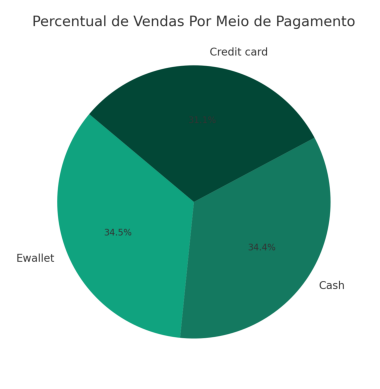

In [83]:
for step in run_steps.data[::-1]:
    print('======= Step >', step.step_details.type)
    if step.step_details.type == 'tool_calls':
        for tool_call in step.step_details.tool_calls:
            print('```')
            print(tool_call.code_interpreter.input)
            print('```')
            if tool_call.code_interpreter.outputs[0].type == 'logs':
                print('Result')
                print(tool_call.code_interpreter.outputs[0].logs)
    if step.step_details.type == 'message_creation':
        message = client.beta.threads.messages.retrieve(
            thread_id=thread.id,
            message_id=step.step_details.message_creation.message_id
        )
        if message.content[0].type == 'text':
            print(message.content[0].text.value)

        if message.content[0].type == 'image_file':
            file_id = message.content[0].image_file.file_id
            image_data = client.files.content(file_id)

            with open(f'arquivos/{file_id}.png', 'wb') as file:
                file.write(image_data.read())

            import matplotlib.pyplot as plt
            import matplotlib.image as mpimg

            img = mpimg.imread(f'arquivos/{file_id}.png')
            fig, ax = plt.subplots()
            ax.set_axis_off()
            ax.imshow(img)
            plt.show()
        